In [1]:
RANDOM_STATE = 1

# Imports

In [2]:
import pandas as pd
import time
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth',300)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

In [3]:
from nltk.corpus import stopwords
import re
import nltk
from nltk import tokenize
from nltk.stem import WordNetLemmatizer

In [4]:
import spacy

# Import datasets from drive

Note - for the purpose of brevity, data has already been preprocessed and cleaned.

In [7]:
#from google.colab import drive
#drive.mount('/content/drive')

In [8]:
import math

In [17]:
# TODO: modify these list if needed (eg. if you want to load only 1 csv from star3, delete other csvs in star3 list)
star3 = ['cleaned_ibis-sg-bencoolen.csv','cleaned_hotel-boss.csv','cleaned_hotel-G.csv',
           'cleaned_village-hotel-albert-court-by-far-east-hospitality.csv',
           'cleaned_holiday-inn-express-clarke-quay.csv']
star4 = ['cleaned_village-hotel-changi-by-far-east-hospitality.csv',
         'cleaned_park-regis.csv', 'cleaned_grand-mercure-sg-roxy.csv',
         'cleaned_paradox-sg-merchant-court.csv','cleaned_crowne-plaza.csv']
star5 = ['cleaned_fullerton.csv', 'cleaned_parkroyal-collection-marina-bay.csv', 'cleaned_pan-pacific.csv',
          'cleaned_mbs_total.csv', 'cleaned_swissotel-the-stamford.csv']
ROOT = ''
RAW_FOLDER = "..\\data\\processed"
def filter_date(row):
  try:
    #print(int(row["date_of_stay"][-4:]))
    print(row["date_of_stay"][-4:])
    return int(row["date_of_stay"][-4:])
  except:
    #print("2000")
    return 2000
def combine_csv_to_dataframe(file_names, all_star = False, filterDate = True):
    """
    Combine multiple CSV files into a single DataFrame.

    Parameters:
    file_names (list): List of CSV file names. 
    all_star (bool): whether or not to load all the hotels (False if only want to load 1 type of hotel star). 
    filterData (bool): whether or not to remove all data dated before 2015

    Returns:
    pd.DataFrame: Combined DataFrame.
    """
    combined_df = pd.DataFrame()

    for file_name in file_names:
        file_name = RAW_FOLDER + "\\" + file_name
        try:
            df = pd.read_csv(file_name)
            if all_star:
              if file_name in star3:
                df["star"] = 3
              elif file_name in star4:
                df["star"] = 4
              else:
                df["star"] = 5
            print(f"Length of {file_name} is {len(df)}")
            combined_df = pd.concat([combined_df, df], ignore_index=True)
        except FileNotFoundError:
            print(f"File not found: {file_name}")
        except pd.errors.EmptyDataError:
            print(f"Empty or invalid CSV file: {file_name}")
    if filterDate:
      combined_df["year"] = combined_df.apply(lambda row: filter_date(row), axis = 1)
      combined_df = combined_df[combined_df["year"]>=2015]
    return combined_df

In [68]:
#data_path = '/content/drive/MyDrive/BT4222/data/mbs_reviews.csv'
df = combine_csv_to_dataframe(star3, all_star = False, filterDate = False)

Length of ..\data\processed\cleaned_ibis-sg-bencoolen.csv is 2217
Length of ..\data\processed\cleaned_hotel-boss.csv is 3568
Length of ..\data\processed\cleaned_hotel-G.csv is 3826
Length of ..\data\processed\cleaned_village-hotel-albert-court-by-far-east-hospitality.csv is 2290
Length of ..\data\processed\cleaned_holiday-inn-express-clarke-quay.csv is 2169


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14070 entries, 0 to 14069
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Unnamed: 0                             14070 non-null  int64  
 1   traveller_username                     14070 non-null  object 
 2   review_title                           14068 non-null  object 
 3   review_text                            14070 non-null  object 
 4   travel_type                            4635 non-null   object 
 5   traveller_country_origin               9922 non-null   object 
 6   traveller_total_contributions          14041 non-null  object 
 7   traveller_total_helpful_contributions  9935 non-null   float64
 8   rating                                 14069 non-null  float64
 9   valid_rating                           14070 non-null  bool   
 10  label                                  14069 non-null  object 
 11  cl

# Data Preprocessing

Then, we split the data into train and validation sets using train_test_split.

In [70]:
df.dropna(subset=['label'], inplace=True)


In [71]:
#df = df[df["label"]!='Neutral']

In [72]:
df['label'] = df['label'].astype('category')


In [73]:
train_set, test_set = train_test_split(df[['lem_review','label']],
                                      test_size=0.2,
                                      shuffle=True,
                                      random_state=RANDOM_STATE)
X_train = train_set.lem_review
y_train = train_set.label
X_test = test_set.lem_review
y_test = test_set.label

In [74]:
train_set

,lem_review,label
9595,ok one night stay room small ok single lightly pack going stay one night kettle room get hot water water fountain hotel far away subway hotel entrance really strange little awkward walk restaurant many place eat around hotel price good budget hotel,Neutral
10324,noise noise noise stay room noise throughout day night sound like renovation move big furniture upstairs disturb get proper sleep annoying part happen almost every min think stop also hot water shower unstable adjust temperature every sec,Negative
12679,second stay nice second stay property six month room comfortable albeit little small side staff good room always clean refresh timely manner room amenity great minor pool outstanding breakfast buffet plenty choice include fresh fruit location wise two block bus stop maybe five minute walk downto...,Positive
1915,nice stay middle bustling area location well locate ibis middle busy area around bugis great cheap shopping street food bencoolen close metro bugis min bus stop front hotel always plenty cheap taxi airport cost take minute walkable distance fort canning mins museum singapore hotel good quick che...,Positive
13852,couple holiday night may easy check check room excellent wifi good definitely stay next visit modern hotel swimming pool excellent staff helpful check check,Positive
...,...,...
905,superb central convenient location ibis hotel go ibis bencoolen par course people experience ibis hotel would expect decent economical star hotel clean contemporary ostentatious pretentious right comfort zone ibis bencoolen become go hotel short medium length stay singapore base upon decade long...,Positive
5192,simple practical lobby pack people apparently many tour group stay hotel however plenty check counter open check fast room small expect cozy nonetheless nice couple much space put big luggage shower clean well equip quite tiny imagine big tall person would feel bit cramp inside okay us love pool...,Positive
12173,clean hotel comfortable sleep check smooth room compact clean complementary parking overnight parking vehicle love smell shower gel soft firm pillow provide pretty much difference make ache severe neck pain thru night disturb love pool water warm time feel comfortable breakfast acceptable spread...,Neutral
235,good central location pick hotel singapore want central close mrt hotel close mrt station bencoolen little india bugis also bus stop right outside hotel orchard rd min walk little india bugis st within walk distance broadway food court base sim lim sq buffett breakfast variety food good standard...,Positive


In [75]:
y_train.value_counts()

Positive    9011
Neutral     1393
Negative     851
Name: label, dtype: int64

The data is very imbalanced, so we will perform undersampling on the train data.

In [76]:
train_set['label'] = train_set['label'].astype('category')


In [77]:
rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_train, y_train = rus.fit_resample(train_set, train_set['label'])
train_set = shuffle(X_train)
train_set.reset_index(inplace=True, drop=True)

In [78]:
X_train = train_set['lem_review']
y_train = train_set['label']

In [79]:
y_train.value_counts()

Negative    851
Neutral     851
Positive    851
Name: label, dtype: int64

We can now use this data for training and testing. To use text data in our machine learning models, we first convert them into TF-IDF vectors.

In [80]:
vectorizer = TfidfVectorizer(use_idf=True,ngram_range=(1,3))
tfidf_features_train = vectorizer.fit_transform(X_train)
tfidf_features_test = vectorizer.transform(X_test)

In [81]:
# save the model to disk
filename = 'tfidf_vectorizer.sav'
pickle.dump(vectorizer, open(filename, 'wb'))

# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))

# Machine Learning Models

## Logistic Regression model

In [82]:
param_grid = {"C":np.logspace(-3,3,7),
              "penalty":["l1","l2"]
              }

lr_model = GridSearchCV(LogisticRegression(),
                        param_grid=param_grid,
                        n_jobs=-1,
                        verbose=5)

#lr_model = LogisticRegression(C=10.0,penalty='l2')
lr_model.fit(tfidf_features_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             verbose=5)

In [83]:
print('Best Parameters found : {}'.format(lr_model.best_params_))
print('Best Accuracy found : {:.3f}\n'.format(lr_model.best_score_))

Best Parameters found : {'C': 1.0, 'penalty': 'l2'}
Best Accuracy found : 0.724



Evaluation on test set

In [84]:
predictions = lr_model.predict(tfidf_features_test)
cm = confusion_matrix(y_test, predictions, labels=lr_model.classes_)

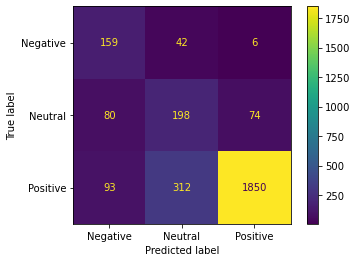

In [85]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
disp.plot()
plt.show()

In [87]:

t1 = time.time()

predictions = lr_model.predict(tfidf_features_test)
t2 = time.time()
print(f'Time Taken {t2-t1} s, {len(y_test)/(t2-t1)} rows per s')
print(sklearn.metrics.classification_report(y_test, predictions, target_names=['Negative', 'Neutral', 'Positive']))
print(sklearn.metrics.confusion_matrix(y_test, predictions, labels=lr_model.classes_))

Time Taken 0.009994029998779297 s, 281568.0961877952 rows per s
              precision    recall  f1-score   support

    Negative       0.48      0.77      0.59       207
     Neutral       0.36      0.56      0.44       352
    Positive       0.96      0.82      0.88      2255

    accuracy                           0.78      2814
   macro avg       0.60      0.72      0.64      2814
weighted avg       0.85      0.78      0.81      2814

[[ 159   42    6]
 [  80  198   74]
 [  93  312 1850]]


## Multinomial Naive Bayes Model

In [88]:
param_grid =  {'alpha':[0, 0.01, 0.1, 0.5, 1.0, 10.0],
               'fit_prior': [True, False],
               'class_prior': [None, [0.1,]*3]
              }

nb_model = GridSearchCV(MultinomialNB(),
                        param_grid=param_grid,
                        n_jobs=-1,
                        verbose=5)
#nb_model = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
nb_model.fit(tfidf_features_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0, 0.01, 0.1, 0.5, 1.0, 10.0],
                         'class_prior': [None, [0.1, 0.1, 0.1]],
                         'fit_prior': [True, False]},
             verbose=5)

In [89]:
print('Best Parameters found : {}'.format(nb_model.best_params_))
print('Best Accuracy found : {:.3f}\n'.format(nb_model.best_score_))

Best Parameters found : {'alpha': 1.0, 'class_prior': None, 'fit_prior': True}
Best Accuracy found : 0.716



Evaluation on test set

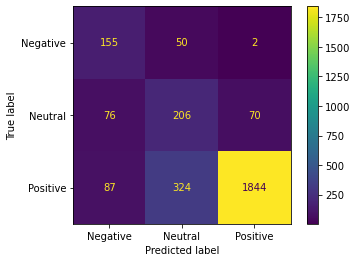

In [90]:
predictions = nb_model.predict(tfidf_features_test)
cm = confusion_matrix(y_test, predictions, labels=nb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_model.classes_)
disp.plot()
plt.show()

In [59]:

t1 = time.time()

predictions = nb_model.predict(tfidf_features_test)
t2 = time.time()
print(f'Time Taken {t2-t1} s, {len(y_test)/(t2-t1)} rows per s')
print(sklearn.metrics.classification_report(y_test, predictions, target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(y_test, predictions, labels=nb_model.classes_))

Time Taken 0.004007577896118164 s, 615084.7379380094 rows per s
              precision    recall  f1-score   support

    Negative       0.58      0.91      0.71       210
    Positive       0.99      0.94      0.96      2255

    accuracy                           0.94      2465
   macro avg       0.79      0.93      0.84      2465
weighted avg       0.96      0.94      0.94      2465

[[ 192   18]
 [ 139 2116]]


## Linear SVM

In [91]:
param_grid =  {'C':[0, 0.01, 0.1, 0.5, 1.0, 10.0],
               'dual': [True, False],
               'penalty': ['l1','l2'],
              }

lsvm_model = GridSearchCV(sklearn.svm.LinearSVC(random_state=RANDOM_STATE),
                        param_grid=param_grid,
                        n_jobs=-1,
                        verbose=5)
#lsvm_model = sklearn.svm.LinearSVC(C=1.0,dual=False,penalty='l1')
lsvm_model.fit(tfidf_features_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(estimator=LinearSVC(random_state=1), n_jobs=-1,
             param_grid={'C': [0, 0.01, 0.1, 0.5, 1.0, 10.0],
                         'dual': [True, False], 'penalty': ['l1', 'l2']},
             verbose=5)

In [92]:
print('Best Parameters found : {}'.format(lsvm_model.best_params_))
print('Best Accuracy found : {:.3f}\n'.format(lsvm_model.best_score_))

Best Parameters found : {'C': 0.5, 'dual': True, 'penalty': 'l2'}
Best Accuracy found : 0.720



Evaluation on test set

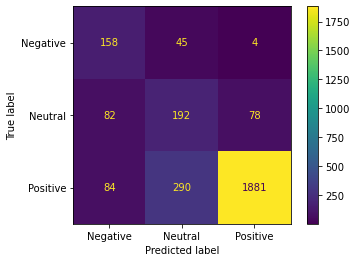

In [93]:
predictions = lsvm_model.predict(tfidf_features_test)
cm = confusion_matrix(y_test, predictions, labels=lsvm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lsvm_model.classes_)
disp.plot()
plt.show()

In [94]:
t1 = time.time()

predictions = lsvm_model.predict(tfidf_features_test)
t2 = time.time()
print(f'Time Taken {t2-t1} s, {len(y_test)/(t2-t1)} rows per s')
print(sklearn.metrics.classification_report(y_test, predictions, target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(y_test, predictions, labels=lsvm_model.classes_))

Time Taken 0.004998445510864258 s, 562975.0277128548 rows per s


ValueError: Number of classes, 3, does not match size of target_names, 2. Try specifying the labels parameter

## Random Forest Classifier

In [95]:
param_grid = {'n_estimators': [100,200],
              'max_features': ['sqrt','log2'],
              'max_depth': [5,10,15],
}

rf_model = GridSearchCV(RandomForestClassifier(),
                        param_grid=param_grid,
                        n_jobs=-1,
                        verbose=5)
#rf_model = RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth=15)
rf_model.fit(tfidf_features_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200]},
             verbose=5)

In [96]:
print('Best Parameters found : {}'.format(rf_model.best_params_))
print('Best Accuracy found : {:.3f}\n'.format(rf_model.best_score_))

Best Parameters found : {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Best Accuracy found : 0.664



Evaluate on test set

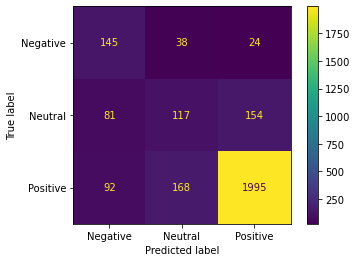

In [97]:
predictions = rf_model.predict(tfidf_features_test)
cm = confusion_matrix(y_test, predictions, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()
plt.show()

In [67]:
t1 = time.time()

predictions = rf_model.predict(tfidf_features_test)
t2 = time.time()
print(f'Time Taken {t2-t1} s, {len(y_test)/(t2-t1)} rows per s')
print(sklearn.metrics.classification_report(y_test, predictions, target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(y_test, predictions, labels=rf_model.classes_))

Time Taken 0.37888193130493164 s, 6505.984572846044 rows per s
              precision    recall  f1-score   support

    Negative       0.54      0.82      0.65       210
    Positive       0.98      0.93      0.96      2255

    accuracy                           0.92      2465
   macro avg       0.76      0.88      0.80      2465
weighted avg       0.94      0.92      0.93      2465

[[ 173   37]
 [ 148 2107]]
